# Mueller's Potential FNO

## Load Data

In [2]:
import sys
sys.path.append('C:/Users/willi/Desktop/UMD REU/mueller/neuraloperator_main')

import neuraloperator_main.neuralop.__init__
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
# from neuralop.models import TFNO

from neuraloperator_main.neuralop.models.tfno import TFNO

from neuralop import Trainer
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

import neuralop 

device = 'cpu'

In [3]:
# load data
mesh = pd.read_csv("mueller_pts.csv", header = None)
committors = pd.read_csv("committorsFEM.csv", header = None).drop(0)
betas = pd.read_csv("betasFEM.csv", header = None).drop(0)
trig = pd.read_csv("mueller_tri.csv", header = None)




In [4]:
dfinput = pd.DataFrame.astype(betas, 'float32')
# dfoutput = pd.DataFrame.astype(committors, 'float32')
dfoutput = committors


In [5]:
datainput = pd.DataFrame.to_numpy(dfinput)

dataoutput = pd.DataFrame.to_numpy(dfoutput)

tri = pd.DataFrame.to_numpy(trig)

grid = pd.DataFrame.to_numpy(mesh)

In [6]:
order = np.arange(len(datainput))
np.random.shuffle(order)

datainput = datainput[order]
dataoutput= dataoutput[order]
    


In [7]:
# split into input/output, test + train

samples = len(datainput)

n_train = int(np.round(.8*samples))
n_test = samples - n_train

x_train = datainput[0:n_train,:]
x_test = datainput[n_train:samples,:]

y_train = dataoutput[0:n_train,:]
y_test = dataoutput[n_train:samples,:]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

print(len(x_train))
print(len(x_test))

80
20


In [8]:
# x_train = x_train[::30]
# y_train = y_train[::30]
# # x_test = x_test[::40]
# # y_test = y_test[::40]
# len(x_train)

In [9]:
trainn = []
testt = []

# turn into dictionary

for i in range(len(x_train)):
    trainn.append({"x": torch.reshape(x_train[i], (77,88)), "y": torch.unsqueeze(torch.reshape(y_train[i], (77,88)), 0)})
    

for i in range(len(x_test)):
    testt.append({"x": torch.reshape(x_test[i], (77,88)), "y": torch.unsqueeze(torch.reshape(y_test[i], (77,88)), 0)})
#removed unsqueeze


In [10]:
trainn[0]['y'].size()

torch.Size([1, 77, 88])

In [11]:
trainn[0]['x'].size()

torch.Size([77, 88])

In [12]:
# append grid?

grid =  pd.DataFrame.astype(mesh, 'float32')
grid = pd.DataFrame.to_numpy(grid)

grid0 = [item[0] for item in grid]
grid1 = [item[1] for item in grid]


grid0 = torch.reshape(torch.Tensor(grid0), (77,88))
grid1 = torch.reshape(torch.Tensor(grid1), (77,88))




In [13]:
#use different resolution grid later?


for i in range(len(trainn)):
    trainn[i]["x"] = torch.stack([trainn[i]["x"], grid0, grid1])
#     trainn[i]["y"] = trainn[i]["y"].unsqueeze(1)


    trainn[i]["x"] = trainn[i]["x"].squeeze()
#     trainn[i]["y"] = trainn[i]["y"].squeeze()

    
for i in range(len(testt)):
    testt[i]["x"] = torch.Tensor(torch.stack([testt[i]["x"], grid0, grid1]))
#     testt[i]["x"] = torch.permute(testt[i]["x"],  (0,2,1))

    
#     testt[i]["y"] = testt[i]["y"].unsqueeze(1)
#     testt[i]["y"] = torch.permute(testt[i]["y"], (0,2,1))


    testt[i]["x"] = testt[i]["x"].squeeze()
#     testt[i]["y"] = testt[i]["y"].squeeze()
    



In [14]:
#1, 1 works here
    
batch_train = 4
batch_test = 1

# load data

    
train_loader = torch.utils.data.DataLoader(trainn, batch_size=batch_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(testt, batch_size=batch_test, shuffle=False)

In [15]:
# for idx, sample in enumerate(train_loader):
#     print(idx)
# #     print("x")
#     print(sample["x"])
#     print(sample["x"].size())
#     print("y")
#     print(sample["y"])
#     print(sample["y"].size())

    
# # x is double tensor wrapped?    

## Create Model

In [16]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', 
               rank=0.42, n_modes_height = 16)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 393665 parameters.


Create the optimizer



In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-5, 
                                weight_decay=1e-4)
optimizer2 = torch.optim.SGD(model.parameters(), 
                             lr = 8e-5, weight_decay = 
                             1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses



In [17]:
# Error metrics:
#
# mean absolute error MAE
# MAE = 1/(#FEM pts) sum_{all FEM pts} |q_{FNO}(x_j) - q_{FEM}(x_j)|
#
# weighted mean absolute error wMAE
#
# wMAE = sum_{all FEM pts} w(x_j)*|q_{FNO}(x_j) - q_{FEM}(x_j)|  
# where
# w(x_j) = exp(-beta*V(x_j))*q(x_j)*(1-q(x_j)) 
# w(x_j) = w(x_j)/sum of all w(x_k)

def MAE(output, target):
    batches = output.size()[0]
    for i in range(batches): 
        x = output[i].reshape(-1)
        y = target[i].reshape(-1)
        error = torch.abs(x - y)*(1/len(x))
    return torch.sum(error)


In [15]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
l1loss = LpLoss(d=2, p=1)

train_loss = h1loss
eval_losses={'h1': h1loss}

In [16]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


NameError: name 'optimizer' is not defined

In [74]:
trainer = Trainer(model, n_epochs=500,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


In [76]:
trainer.train(train_loader, test_loader,
              None,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 80 samples
Testing on [20] samples         on resolutions ['test'].
Training on raw inputs of size x.shape=torch.Size([4, 3, 77, 88]), y.shape=torch.Size([4, 1, 77, 88])
.. patched inputs of size x.shape=torch.Size([4, 3, 77, 88]), y.shape=torch.Size([4, 1, 77, 88])
Raw outputs of size out.shape=torch.Size([4, 1, 77, 88])
.. Processed (unpatched) outputs of size out.shape=torch.Size([4, 1, 77, 88])
[0] time=4.37, avg_loss=0.0025, train_err=0.0157, test_h1=0.0154
[3] time=4.09, avg_loss=0.0025, train_err=0.0155, test_h1=0.0152
[6] time=4.25, avg_loss=0.0024, train_err=0.0152, test_h1=0.0151
[9] time=4.35, avg_loss=0.0024, train_err=0.0151, test_h1=0.0152
[12] time=4.18, avg_loss=0.0024, train_err=0.0152, test_h1=0.0152
[15] time=3.97, avg_loss=0.0024, train_err=0.0150, test_h1=0.0162
[18] time=4.06, avg_loss=0.0024, train_err=0.0148, test_h1=0.0149
[21] time=4.07, avg_loss=0.0023, train_err=0.0146, test_h1=0.0148
[24] time=4.12, avg_loss=0.0023, train_err=0.0146, test_h1=0.0

In [27]:
#torch.save(model.state_dict(), '2000epochs.txt')
model.load_state_dict(torch.load('500epochs.txt'))

<All keys matched successfully>

In [19]:
def mueller(x):
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    D = np.array([-200,-100,-170,15])
    X = np.array([1,0,-0.5,-1])
    Y = np.array([0,0.5,1.5,1])
  
    fx1 = D[0]*np.exp(a[0]*((x[:,0]-X[0])**(2)) + b[0]*(x[:,0]-X[0])*(x[:,1]-Y[0]) + c[0]*((x[:,1]-Y[0])**(2)))
    fx2 = D[1]*np.exp(a[1]*((x[:,0]-X[1])**(2)) + b[1]*(x[:,0]-X[1])*(x[:,1]-Y[1]) + c[1]*((x[:,1]-Y[1])**(2)))
    fx3 = D[2]*np.exp(a[2]*((x[:,0]-X[2])**(2)) + b[2]*(x[:,0]-X[2])*(x[:,1]-Y[2]) + c[2]*((x[:,1]-Y[2])**(2)))
    fx4 = D[3]*np.exp(a[3]*((x[:,0]-X[3])**(2)) + b[3]*(x[:,0]-X[3])*(x[:,1]-Y[3]) + c[3]*((x[:,1]-Y[3])**(2)))
    
    U = fx1+fx2+fx3+fx4
    return U


In [23]:
# Error metrics:
#
# mean absolute error MAE
# MAE = 1/(#FEM pts) sum_{all FEM pts} |q_{FNO}(x_j) - q_{FEM}(x_j)|
#
# weighted mean absolute error wMAE
#
# wMAE = sum_{all FEM pts} w(x_j)*|q_{FNO}(x_j) - q_{FEM}(x_j)|  
# where
# w(x_j) = exp(-beta*V(x_j))*q(x_j)*(1-q(x_j)) 
# w(x_j) = w(x_j)/sum of all w(x_k)

def wMAE(output, target, beta):
#     x = output[i].reshape(-1)
#     y = target[i].reshape(-1)
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    potential = torch.Tensor(mueller(grid))
    weights = torch.squeeze(torch.exp(-beta*potential)*y*(1-y))
    
    Z = torch.sum(weights)
    error = torch.squeeze(torch.abs(x - y)*weights*(1/Z))
    error = torch.sum(error)
    
    return error 

def MAE2(target,output):
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    error = torch.squeeze(torch.abs(x - y))*(1/x.size(0))
    error = torch.sum(error)
                          
    return error

In [28]:
MAE2error = 0
WMAEerror = 0
test_samples = test_loader.dataset

for data in test_samples: 
    x = data['x']
    y = data['y']

    out = model(x.unsqueeze(0))
    
    out = out.detach().numpy()[0][0]

    out = np.reshape(out, -1)

    y = y.detach().numpy()
    y = np.reshape(y, -1)

    beta = x.numpy()[0][0][0]

    MAE2error += MAE2(out, y)
    WMAEerror += wMAE(out, y, beta)



MAE2error = MAE2error / 20
WMAEerror = WMAEerror / 20

print(MAE2error)
print(WMAEerror)


tensor(0.0096)
tensor(0.0204)


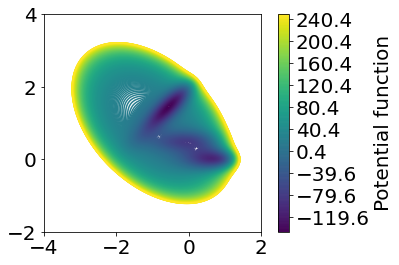

In [98]:
# parameters for Mueller's potential
xa=-0.558
ya=1.441 
xb=0.623 
yb=0.028

# problem setup: choose sets A and B and the outer boundary
# set A is the circle with center at (xa,ya) and radius ra
# set B is the circle with center at (xb,yb) and radius rb
ra = 0.1 # radius of set A
rb = 0.1 # radius of set B
beta = 0.5 # beta = 1/(k_B T), T = temperature, k_B = Boltzmann's constant
Vbdry = 250 # level set of the outer boundary {x : fpot(x) = Vbdry}

# if generate_mesh = True, mesh is generated and saved as csv files
# if generate_mesh = False, mesh is downloaded from those csv files
generate_mesh = True

# h0 is the desired scaling parameter for the mesh
h0 = 0.05


def mueller(x):
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    D = np.array([-200,-100,-170,15])
    X = np.array([1,0,-0.5,-1])
    Y = np.array([0,0.5,1.5,1])
  
    fx1 = D[0]*np.exp(a[0]*((x[:,0]-X[0])**(2)) + b[0]*(x[:,0]-X[0])*(x[:,1]-Y[0]) + c[0]*((x[:,1]-Y[0])**(2)))
    fx2 = D[1]*np.exp(a[1]*((x[:,0]-X[1])**(2)) + b[1]*(x[:,0]-X[1])*(x[:,1]-Y[1]) + c[1]*((x[:,1]-Y[1])**(2)))
    fx3 = D[2]*np.exp(a[2]*((x[:,0]-X[2])**(2)) + b[2]*(x[:,0]-X[2])*(x[:,1]-Y[2]) + c[2]*((x[:,1]-Y[2])**(2)))
    fx4 = D[3]*np.exp(a[3]*((x[:,0]-X[3])**(2)) + b[3]*(x[:,0]-X[3])*(x[:,1]-Y[3]) + c[3]*((x[:,1]-Y[3])**(2)))
    
    U = fx1+fx2+fx3+fx4
    return U

# define the potential on a meshgrid

#changed here for square grid
nx,ny= (120,120)
nxy = nx*ny
xmin = -4.0
xmax = 2.0
ymin = -2
ymax = 4
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax ,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))
v = np.zeros(nxy)
xy = np.concatenate((x_vec,y_vec),axis=1)
v = mueller(xy)
vmin = np.amin(v)
v_grid = np.reshape(v,(nx,ny))    
# graphics
plt.rcParams.update({'font.size': 20})
ls = plt.contour(x_grid,y_grid,v_grid,np.arange(vmin,Vbdry,1))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)


In [31]:
test_samples = test_loader.dataset

data = test_samples[i]

x = data['x']
y = data['y']

out = model(x.unsqueeze(0))
    
out = out.detach().numpy()[0][0]

out = np.reshape(out, -1)

beta = x.numpy()[0][0][0]

print("beta is" + " " + str(beta))
y = y.detach().numpy()
y = np.reshape(y, -1)


error = wMAE(out, y, beta)
error = error.numpy()
print("WMAE error is "+ " " + str(error))

error = MAE2(out, y)
error = error.numpy()

print("MAE error is " + " " + str(error) )

beta is 0.2
WMAE error is  18.895578
MAE error is  41.347153


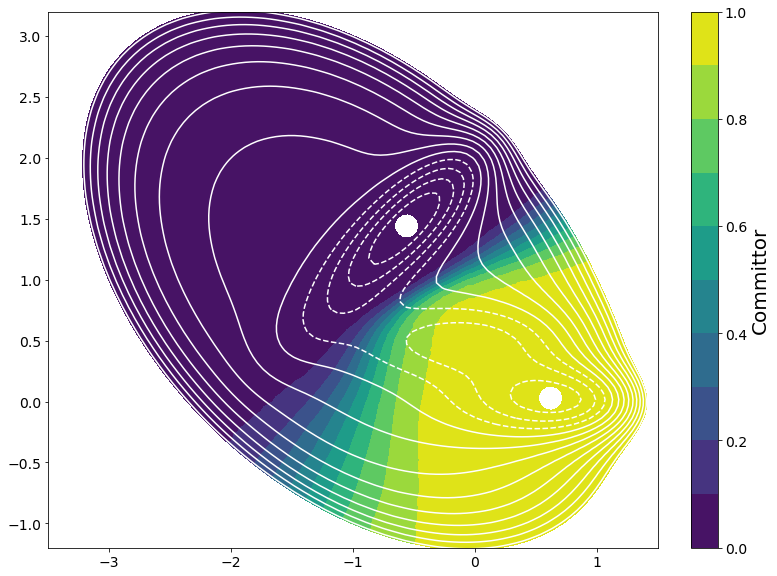

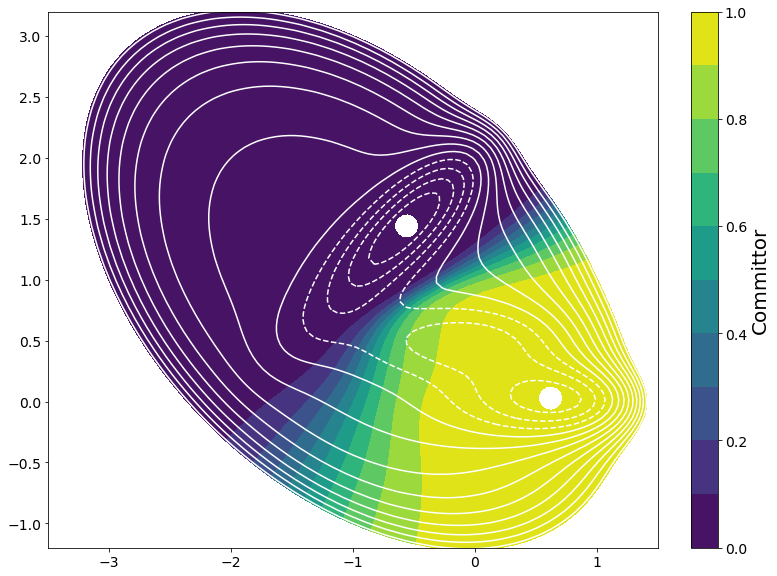

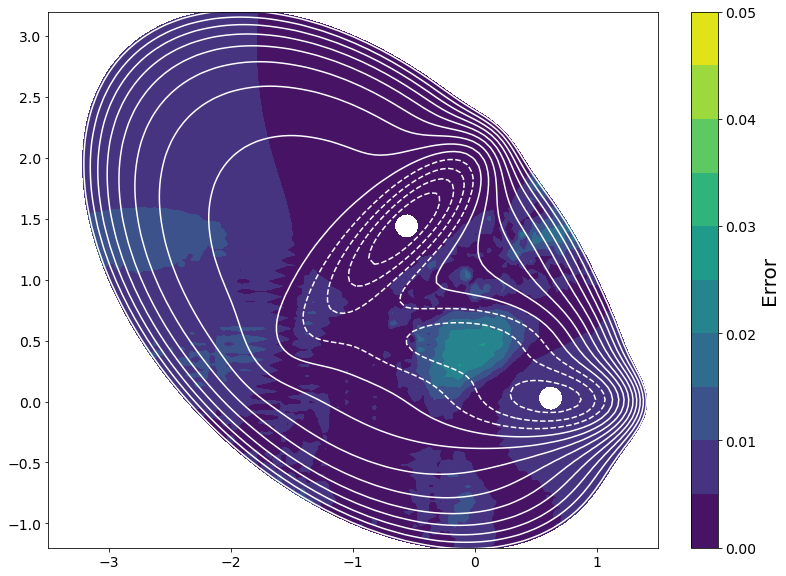

In [194]:
fig1 = plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plt.tricontourf(grid[:,0], grid[:,1],tri, out , np.linspace(0, 1, 11))


plt.colorbar(label="Committor", orientation="vertical", fraction=0.04, pad=0.05)
plt.contour(x_grid,y_grid,v_grid, np.arange(vmin,Vbdry,30), colors='white')
plt.xlim([-3.5,1.5])
plt.ylim([-1.2,3.2])


axes=plt.gca()
axes.set_aspect(1)
# plt.rcParams.update({'font.size': 20})
# plt.title("FNO committor for beta" + "=" + str(round(beta, 2)))

plt.savefig(".18FNO_model.pdf")



fig2 = plt.figure(figsize=(12, 12))

plt.tricontourf(grid[:,0], grid[:,1],tri, y, np.linspace(0, 1, 11))
plt.colorbar(label="Committor", orientation="vertical", fraction=0.04, pad=0.05)
plt.contour(x_grid,y_grid,v_grid, np.arange(vmin,Vbdry,30), colors='white')

axes=plt.gca()
axes.set_aspect(1)
# plt.rcParams.update({'font.size': 20})
# plt.title("Ground Truth Committor for beta" + "=" + str(round(beta, 4)))
plt.xlim([-3.5,1.5])
plt.ylim([-1.2,3.2])
plt.savefig(".18FEM_committor.pdf")

fig2 = plt.figure(figsize=(12, 12))

plt.tricontourf(grid[:,0], grid[:,1],tri, np.abs(out - y), np.linspace(0, .05, 11))
plt.colorbar(label="Error", orientation="vertical",  fraction=0.04, pad=0.05)
plt.contour(x_grid,y_grid,v_grid, np.arange(vmin,Vbdry,30), colors='white')
plt.xlim([-3.5,1.5])
plt.ylim([-1.2,3.2])
# plt.title("Absolute Error," + "β = " +str(round(beta, 4)))
axes=plt.gca()
axes.set_aspect(1)
plt.savefig(".18absolute_error.pdf")


#.18


In [306]:
print(y)

[8.1202481e-04 7.9366425e-04 8.2835939e-04 ... 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


In [25]:
for i in out:
#     if i < 0: 
#         print(i)
#     print("too big now")
#     if i > 1:
#         print(i)
    print(i)

0.36826187
0.36807296
0.36845773
0.36788812
0.36865547
0.36770484
0.3688537
0.36752245
0.36905193
0.36734134
0.36925077
0.36716253
0.36945093
0.3669883
0.36965275
0.3680756
0.36841664
0.36781245
0.36877644
0.36985177
0.36681202
0.36824942
0.3685951
0.36762974
0.3689548
0.37004015
0.36728755
0.36662912
0.3693236
0.36794385
0.36746484
0.3691363
0.37024078
0.36954287
0.36646196
0.36712956
0.36693648
0.37044394
0.3697471
0.3684462
0.3687936
0.36813048
0.36779648
0.36630446
0.37065288
0.3699466
0.3667854
0.36899102
0.3673419
0.36946264
0.36764866
0.36864865
0.37013945
0.36832243
0.36664093
0.3693058
0.3708714
0.36799738
0.3661601
0.37035492
0.36707082
0.36966285
0.3664627
0.3675143
0.37106982
0.36915815
0.36722663
0.37055063
0.36883846
0.36599514
0.36849943
0.36691105
0.3698437
0.3678295
0.36816737
0.36629665
0.371264
0.3694987
0.3702171
0.36660427
0.37074178
0.3700399
0.3709288
0.36768526
0.3690136
0.36676744
0.36868373
0.36738953
0.3658443
0.36835113
0.3693404
0.37147096
0.36802164
0.3661